In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdDistGeom import EmbedMolecule
import multiprocessing

In [ ]:
#IO
temp = 450
run = 4
cwd = os.path.join('kMC run 8 - eventfreq',f'Temp_{temp}C',f'final_iteration_{run}')
events_json = os.path.join(cwd,'events.json')
population_json = os.path.join(cwd,'population history.json')
rates_json = os.path.join(cwd,'reaction rates.json')
species_csv = os.path.join(cwd,'species list.csv')
all_species_json = os.path.join(cwd,'swept species.json')
timing_json = os.path.join(cwd,'timing.json')
k_json = f'{temp}_rate constants.json'

species_list = pd.read_csv(species_csv)
try:
    exp_csv = f'{temp}_exp.csv'
    exp = pd.read_csv(exp_csv)
except FileNotFoundError:
    pass
    
try:
    smiles_csv = os.path.join(cwd,'vw vol.csv')
    smiles_list = pd.read_csv(smiles_csv)
    
except FileNotFoundError:
    smiles_list = species_list[['Species SMILES','Molecular Weight']]
    

events = pd.read_json(events_json).transpose()
pop = pd.read_json(all_species_json).transpose()
pop=pop.reset_index()
pop=pop.rename(columns={"index": "Species"})
timing = pd.read_json(timing_json)
k = pd.read_json(k_json)

c_n = len(exp)
k = k.reset_index()
k = k.rename(columns={"index": "Reaction","0":'Rate Constant'})
k['Reaction'] = k['Reaction'].str.replace('rxn','')
k['Reaction'] = pd.to_numeric(k['Reaction'], errors='coerce')

#Label reactions
reaction_category = {'Initiation':[1,2,3,4,5,6,7],
                    'Radical Recombination':[8,9,10,11,12,13,14,15],
                    'Hydrogen Abstraction':[16,17,18,19,20,21,22,23,24,25,26,27,28],
                    'Backbiting':[29,30,31,32,33,34,35,36,37,38,39,40,41],
                    'Radical Disproportionation':[42,43,44,45,46,47,48,49],
                    'Beta Scission':[51,52,53,54,55],
                    'Addition Reactions':[56,57,58,59,60,61,62,63],
                    }
k=k.sort_values('Reaction')


In [ ]:
##HELPER FUNCTIONS

def table_lump(df,cnum):
    lumped_c = {}
    for i in cnum:
        lb = i[0]
        ub = i[1]
        lumped_c[f'C{lb}-C{ub}'] = df[(df['Chain Length']>=lb)&(df['Chain Length']<=ub)]['Wt%'].sum()
    return lumped_c

def lump(df,c):
    lumped_c = {}
    for i in range(5,c+5):
        lumped_c[f'C{i}'] = df[df['Chain Length']==i]['Wt%'].sum()
    return lumped_c

def calculate_vdw_volume(chunk):
    from rdkit import Chem
    from rdkit.Chem import AllChem
    results = []
    for idx, row in chunk.iterrows():
        s = Chem.AddHs(Chem.MolFromSmiles(row['Species SMILES']))
        EmbedMolecule(s, useRandomCoords=True)
        vol = AllChem.ComputeMolVolume(s)
        results.append((idx, vol))
    return results

def big_lump(df,cnum,pop):

    lumped_c = []
    low=cnum[0][0]
    high=cnum[0][1]
    for i in range(len(events)):
        df2 = df[(df['Chain Length']>=low)&(df['Chain Length']<=high)]
        tot_wt = (pop[i]*pop['Molecular Weight']).sum()
        wt_percent = ((df2[i]*df2['Molecular Weight']).sum())*100/tot_wt
        lumped_c += [wt_percent]
    return lumped_c

def process_df(df, cnum, pop, num_processes):
    lumped_c = []
    pool = multiprocessing.Pool(processes=num_processes)
    results = []
    for i in range(len(events)):
        result = pool.apply_async(big_lump, (df, cnum, pop, i))
        results.append(result)
    pool.close()
    pool.join()
    lumped_c = [result.get() for result in results]
    return lumped_c




In [ ]:
#Stats

species_list['Final Population'] = species_list['Current Population']+list(pop[run])
spfilter = species_list[(species_list['Final Population']>0) & (~species_list['Species SMILES'].str.contains(r'\[.*\]')) & (species_list['Chain Length']>0)& (species_list['Chain Length']<=60)][['Species SMILES','Chain Length', 'Final Population','Molecular Weight','Double Bond?']]


spfilter['Total Weight'] = spfilter['Final Population']*spfilter['Molecular Weight']
spfilter['Wt%'] = (spfilter['Total Weight']/spfilter['Total Weight'].sum())*100
aliphatic = spfilter[['Species SMILES','Chain Length','Wt%']]
olefinic = spfilter[spfilter['Double Bond?']==True][['Species SMILES','Chain Length','Wt%']]
paraffinic = spfilter[spfilter['Double Bond?']==False][['Species SMILES','Chain Length','Wt%']]

crange_ole = [[1,4],[5,12],[13,20],[21,30],[31,60]]
crange = [[1,4],[5,12],[13,20],[21,30],[31,60]]
table = pd.DataFrame()
table['Olefins Wt%'] = table_lump(olefinic,crange_ole)
table['Paraffins Wt%'] = table_lump(paraffinic,crange)
table['Total Wt%'] = table_lump(aliphatic,crange)
table=table.reset_index()
table=table.rename(columns = {'index':'Lumped Fraction'})

table.to_csv(os.path.join(cwd, 'wt table.csv'), index=False)

avg_rr = timing['Reaction Rate Calc'].mean()
avg_choose = timing['Choose Reaction'].mean()
avg_log = timing['Log Events'].mean()
avg_react = timing['Reaction'].mean()
avg_pop = timing['Update Population'].mean()
avg_df = timing['Update DF'].mean()

avg_t = timing.mean()
avg_time = avg_t.sum()
tot_t = timing.sum()
tot_time = tot_t.sum()

n_sp = len(species_list)
n_ev = len(events)-1

table_dat={'Number of species tracked':n_sp,
          'Number of reaction events':n_ev,
          'Average Time per Iteration':avg_time,
         'Total Compute Time':tot_time/3600,
          }

with open(os.path.join(cwd, 'table_dat.json'), 'w') as json_file:
    json.dump(table_dat, json_file)

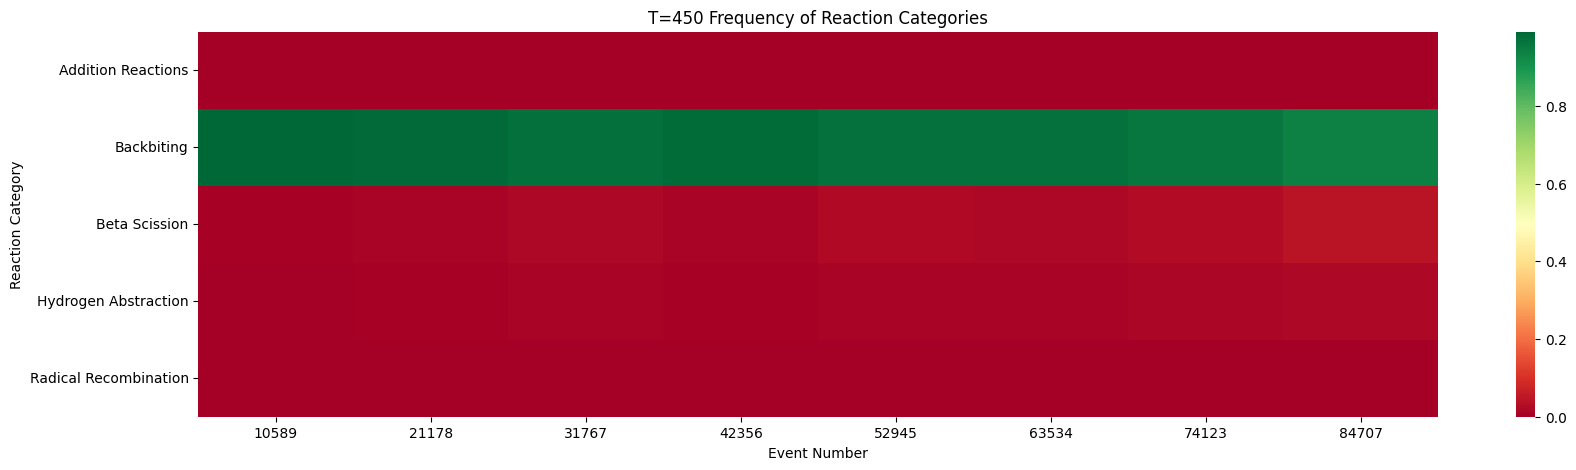

In [ ]:
#Event Frequency Heatmap
reaction_cat = {}


for x,y in reaction_category.items():
    for i in y:
        reaction_cat['rxn'+str(i)]=x



events['Reaction Category'] = events['reaction'].map(reaction_cat)

event_interval = 50

#Create a set of all possible reaction categories
all_reaction_categories = events['Reaction Category'].unique()

#Create a dictionary to store frequency counts for each interval
interval_freq_counts = {}

#Calculate the total number of intervals
total_intervals = 8
event_interval = int(np.ceil(len(events) / total_intervals))

#Iterate through intervals
for interval in range(total_intervals):
    start_idx = interval * event_interval
    end_idx = min((interval + 1) * event_interval, len(events))
    interval_data = events.iloc[start_idx:end_idx]

    #Calculate the frequency of each reaction category in this interval
    freq_counts = interval_data['Reaction Category'].value_counts()

    #Store frequency counts in the dictionary
    interval_freq_counts[end_idx] = freq_counts

#Convert the dictionary to a DataFrame
heatmap_data = pd.DataFrame(interval_freq_counts).fillna(0)

#Normalize the data for better color representation
heatmap_data_normalized = heatmap_data.div(heatmap_data.sum(axis=0), axis=1)

#Create the heatmap
plt.figure(figsize=(20, 5))
sns.heatmap(heatmap_data_normalized, cmap='RdYlGn', annot=False, fmt='.2f')
plt.xlabel('Event Number')
plt.title(f'T={temp} Frequency of Reaction Categories')

plt.savefig(os.path.join(cwd,f'{temp}C_heatmap.png'),dpi=300)

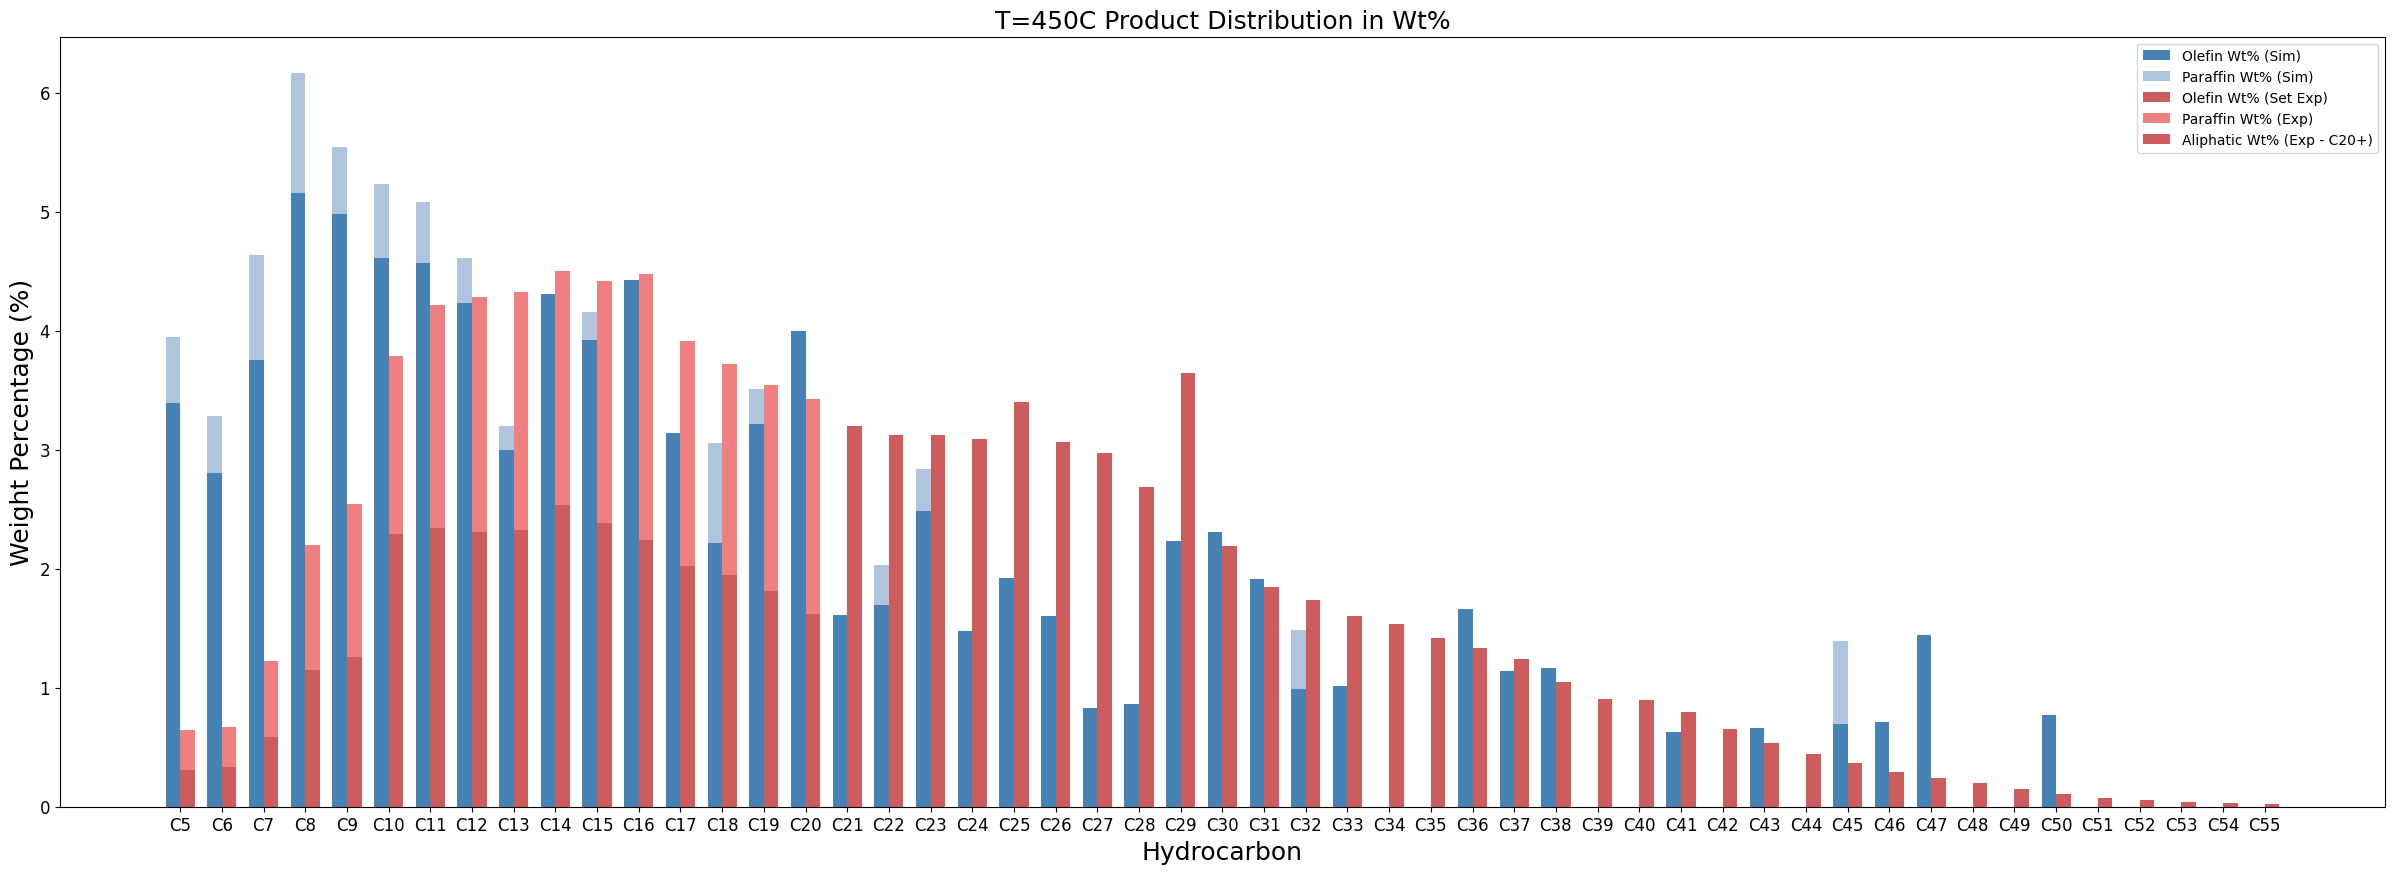

In [ ]:
#Group by Cn for Model validation
species_list['Final Population'] = species_list['Current Population']+list(pop[run])
spfilter = species_list[(species_list['Final Population']>0) & (~species_list['Species SMILES'].str.contains(r'\[.*\]')) & (species_list['Chain Length']>4)& (species_list['Chain Length']<=c_n)][['Species SMILES','Chain Length', 'Final Population','Molecular Weight','Double Bond?']]


spfilter['Total Weight'] = spfilter['Final Population']*spfilter['Molecular Weight']
spfilter['Wt%'] = (spfilter['Total Weight']/spfilter['Total Weight'].sum())*100
aliphatic = spfilter[['Species SMILES','Chain Length','Wt%']]
olefinic = spfilter[spfilter['Double Bond?']==True][['Species SMILES','Chain Length','Wt%']]
paraffinic = spfilter[spfilter['Double Bond?']==False][['Species SMILES','Chain Length','Wt%']]

lumped_ali = lump(aliphatic,c_n)
lumped_ole = lump(olefinic,c_n)
lumped_para = lump(paraffinic,c_n)

lumped_prod = pd.DataFrame()
lumped_prod['Olefin Wt%'] = lumped_ole
lumped_prod['Paraffin Wt%'] = lumped_para
lumped_prod['Total Wt%'] = lumped_ali
lumped_prod.to_csv(os.path.join(cwd, f'{temp}_lumped.csv'), index=True)
lumped_prod = lumped_prod.reset_index()
lumped_prod = lumped_prod.rename(columns={"index": "Component"})

#Set the figure size
plt.figure(figsize=(30, 10))

#Define the width of the bars
bar_width = 0.35

#Create an array of x positions for the bars
x = np.arange(len(lumped_prod['Component']))

#Plot the first set of data
plt.bar(x - bar_width/2, lumped_prod['Olefin Wt%'], bar_width, label='Olefin Wt% (Sim)', color='steelblue')
plt.bar(x - bar_width/2, lumped_prod['Paraffin Wt%'], bar_width, bottom=lumped_prod['Olefin Wt%'], label='Paraffin Wt% (Sim)', color='lightsteelblue')

#Plot the second set of data next to the first set
plt.bar(x + bar_width/2, exp['Olefins Wt%'], bar_width, label='Olefin Wt% (Set Exp)',color='indianred')
plt.bar(x + bar_width/2, exp['Paraffins Wt%'], bar_width, bottom=exp['Olefins Wt%'], label='Paraffin Wt% (Exp)',color='lightcoral')
plt.bar(x + bar_width/2, exp['Aliphatic Wt%'] - exp['Paraffins Wt%'] - exp['Olefins Wt%'],
        bar_width, bottom=exp['Paraffins Wt%'] + exp['Olefins Wt%'], label='Aliphatic Wt% (Exp - C20+)',color='indianred')

#Add labels and title
plt.xlabel('Hydrocarbon', fontsize=18)
plt.ylabel('Weight Percentage (%)',fontsize = 18)
plt.title(f'T={temp}C Product Distribution in Wt%', fontsize=18)

#Add legend
plt.legend()

#Set x-axis ticks and labels
plt.xticks(x, lumped_prod['Component'], fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig(os.path.join(cwd,f'{temp}C_model_validation.png'),dpi=300)
plt.show()



In [ ]:
# #Species in reactive system
# spfilter1 = species_list[(species_list['Current Population']>0) & (~species_list['Species SMILES'].str.contains(r'\[.*\]')) & (species_list['Chain Length']>4) & (species_list['Chain Length']<=c_n)][['Species SMILES','Chain Length', 'Current Population','Molecular Weight','Double Bond?']]


# spfilter1['Total Weight'] = spfilter1['Current Population']*spfilter1['Molecular Weight']
# spfilter1['Wt%'] = (spfilter1['Total Weight']/spfilter1['Total Weight'].sum())*100
# aliphatic1 = spfilter1[['Species SMILES','Chain Length','Wt%']]
# olefinic1 = spfilter1[spfilter1['Double Bond?']==True][['Species SMILES','Chain Length','Wt%']]
# paraffinic1 = spfilter1[spfilter1['Double Bond?']==False][['Species SMILES','Chain Length','Wt%']]

# def lump(df,c):
#     lumped_c = {}
#     for i in range(5,c+5):
#         lumped_c[f'C{i}'] = df[df['Chain Length']==i]['Wt%'].sum()
#     return lumped_c

# lumped_ali1 = lump(aliphatic1,c_n)
# lumped_ole1 = lump(olefinic1,c_n)
# lumped_para1 = lump(paraffinic1,c_n)

# lumped_prod1 = pd.DataFrame()
# lumped_prod1['Olefin Wt%'] = lumped_ole1
# lumped_prod1['Paraffin Wt%'] = lumped_para1
# lumped_prod1['Total Wt%'] = lumped_ali1
# lumped_prod1
# lumped_prod1.to_csv(os.path.join(cwd, f'{temp}_lumped1.csv'), index=True)
# lumped_prod1 = lumped_prod1.reset_index()
# lumped_prod1 = lumped_prod1.rename(columns={"index": "Component"})

# #Set the figure size
# plt.figure(figsize=(30, 10))

# #Define the width of the bars
# bar_width = 0.35

# #Create an array of x positions for the bars
# x = np.arange(len(lumped_prod['Component']))

# #Plot the first set of data
# plt.bar(x - bar_width/2, lumped_prod1['Olefin Wt%'], bar_width, label='Olefin Wt% (Sim)', color='steelblue')
# plt.bar(x - bar_width/2, lumped_prod1['Paraffin Wt%'], bar_width, bottom=lumped_prod1['Olefin Wt%'], label='Paraffin Wt% (Sim)', color='lightsteelblue')

# #Plot the second set of data next to the first set
# plt.bar(x + bar_width/2, exp['Olefins Wt%'], bar_width, label='Olefin Wt% (Set Exp)',color='indianred')
# plt.bar(x + bar_width/2, exp['Paraffins Wt%'], bar_width, bottom=exp['Olefins Wt%'], label='Paraffin Wt% (Exp)',color='lightcoral')
# plt.bar(x + bar_width/2, exp['Aliphatic Wt%'] - exp['Paraffins Wt%'] - exp['Olefins Wt%'],
#         bar_width, bottom=exp['Paraffins Wt%'] + exp['Olefins Wt%'], label='Aliphatic Wt% (Exp - C20+)',color='indianred')

# #Add labels and title
# plt.xlabel('Hydrocarbon', fontsize=18)
# plt.ylabel('Weight Percentage (%)',fontsize = 18)
# plt.title(f'T={temp}C Product Distribution in Wt%', fontsize=18)

# #Add legend
# plt.legend()

# #Set x-axis ticks and labels
# plt.xticks(x, lumped_prod1['Component'], fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.show()

In [ ]:
#Calculate van der Waals volume
num_processes = 8
chunk_size = len(species_list) // num_processes
chunks = [smiles_list[i:i + chunk_size] for i in range(0, len(smiles_list), chunk_size)]


pool = multiprocessing.Pool(processes=num_processes)


results = pool.map(calculate_vdw_volume, chunks)


pool.close()
pool.join()


volume_data = []
for result in results:
    volume_data.extend(result)

for idx, vol in volume_data:
    smiles_list.loc[idx, 'VW Vol'] = vol
    

smiles_list.to_csv(os.path.join(cwd, 'vw vol.csv'), index=False)

CPU times: total: 219 ms
Wall time: 26min 22s


<timed exec>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [139]:
k_init=0
k_term=0
for i in reaction_category['Initiation']:
    r_init = k[k['Reaction']==i]
    k_init += r_init[0].sum()
    
for i in (reaction_category['Radical Recombination']+reaction_category['Radical Disproportionation']):
    r_term = k[k['Reaction']==i]
    k_term += r_term[0].sum()    

r_init = k[k['Reaction']<8]
k_init = r_init[0].sum()
r_term = k[((k['Reaction']>7)&(k['Reaction']<16))|((k['Reaction']>41)&(k['Reaction']<50))]
k_term = r_term[0].sum()
feed_conc = 950/3267466
rad_qss = (k_init*feed_conc/k_term)**0.5


rad_mol = []
sys_vol = []
rad_conc = []
avo_num = 6.02214*10**23

for i in range(len(events)):
    event_pop = pd.DataFrame()
    event_pop['Species'] = pop['Species']
    event_pop[i] = pop[i]
    event_pop['VW Vol'] = smiles_list[['VW Vol']]
    event_pop['Vol'] = (event_pop[i]/avo_num)*event_pop['VW Vol']
    tot_vol = event_pop['Vol'].sum()
    rad_df = event_pop[(event_pop['Species'].str.contains(r'\[.*\]'))&(event_pop['Species']!='[H][H]')&(event_pop[i]>0)]
    radical_mol = (rad_df[i].sum())/avo_num
    radical_conc = radical_mol/tot_vol
    sys_vol += [tot_vol]
    rad_mol += [radical_mol]
    rad_conc += [radical_conc]

events['system volume'] = sys_vol
events['radical conc'] = rad_conc
events['radical mols'] = rad_mol

events['scaled tau'] = events['tau']*events['radical conc']/rad_qss
events['scaled time'] = events['scaled tau'].cumsum()
events['scaled tau'].sum()

443.1857444017376

In [125]:
pop['Chain Length'] = species_list['Chain Length']
pop['Double Bond?'] = species_list['Double Bond?']
pop['Molecular Weight'] = species_list['Molecular Weight']
popfilter = pop[(~pop['Species'].str.contains(r'\[.*\]'))]
olefins_popdf = popfilter[(popfilter['Double Bond?']==True)&(popfilter['Species'].str.len()<60)]
paraffins_popdf = popfilter[(popfilter['Double Bond?']==False)&(popfilter['Species'].str.len()<60)]
aliphatic_popdf = popfilter[popfilter['Species'].str.len()<60]
feed_df = popfilter[(popfilter['Chain Length']==100)&(popfilter['Double Bond?']==False)]
wtdf = pd.DataFrame()
wtdf['Time'] = events['scaled time']
for i in range(len(events)):
    weighted_chain = (popfilter[i]*popfilter['Chain Length']).sum()
    tot_pop = popfilter[i].sum()
    avg_chain = weighted_chain/tot_pop
    tot_wt = (popfilter[i] * popfilter['Molecular Weight']).sum()
    wtdf.loc[i, 'Time'] = events.at[i, 'scaled time']*1000
    wtdf.loc[i, 'Olefin Wt%'] = ((olefins_popdf[i] * olefins_popdf['Molecular Weight']).sum()) * 100 / tot_wt
    wtdf.loc[i, 'Paraffin Wt%'] = ((paraffins_popdf[i] * paraffins_popdf['Molecular Weight']).sum()) * 100 / tot_wt
    wtdf.loc[i, 'Feed Wt%'] = (feed_df[i].iloc[0] * feed_df['Molecular Weight'].iloc[0]) * 100 / tot_wt
    wtdf.loc[i, 'Weighted Average Chain Length'] = avg_chain


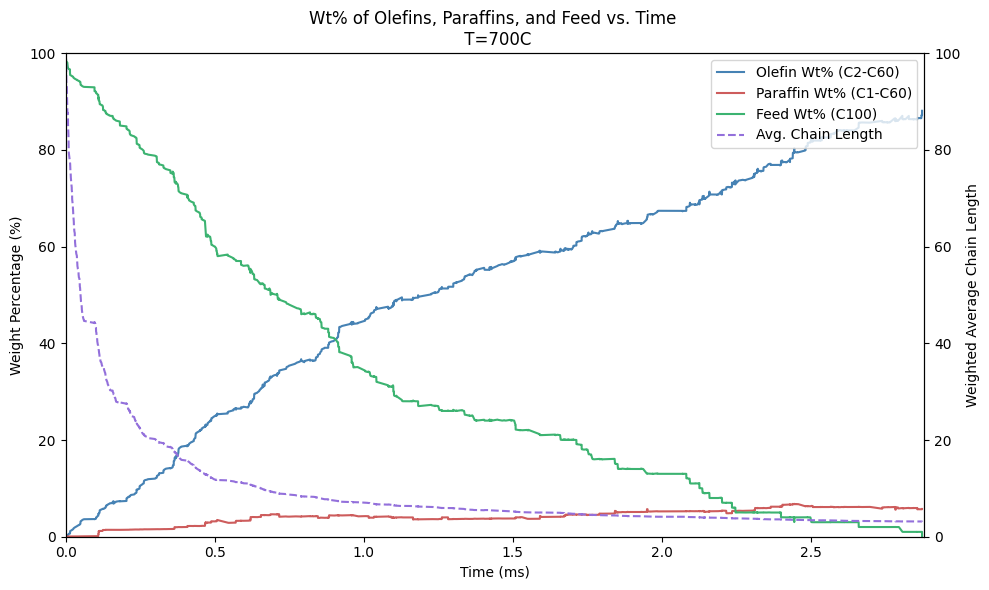

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(wtdf['Time'], wtdf['Olefin Wt%'], label='Olefin Wt% (C2-C60)', color='steelblue')
ax1.plot(wtdf['Time'], wtdf['Paraffin Wt%'], label='Paraffin Wt% (C1-C60)', color='indianred')
ax1.plot(wtdf['Time'], wtdf['Feed Wt%'], label='Feed Wt% (C100)', color='mediumseagreen')


ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Weight Percentage (%)')
ax1.set_title(f'Wt% of Olefins, Paraffins, and Feed vs. Time \n T={temp}C')
ax1.set_ylim(0,100)
ax1.set_xlim(0,2.88)


ax2 = ax1.twinx()
ax2.plot(wtdf['Time'], wtdf['Weighted Average Chain Length'], linestyle='--', color='mediumpurple', label='Avg. Chain Length')
ax2.set_ylabel('Weighted Average Chain Length')
ax2.set_ylim(0,100)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.savefig(os.path.join(cwd,f'{temp}C_olefin wt%.png'),dpi=300)
plt.tight_layout()
plt.show()

In [ ]:
lumped_dist = pd.DataFrame()
lumped_dist['Time'] = wtdf['Time']
lumped_dist['Feed (C100)'] = wtdf['Feed Wt%']
lumped_dist['Light Olefins (C2-C6)'] = big_lump(olefins_popdf,[(2,6)],popfilter)
lumped_dist['Light Paraffins (C1-C6)'] = big_lump(paraffins_popdf,[(1,6)],popfilter)
lumped_dist['Intermediate Olefins (C7-C18)'] = big_lump(olefins_popdf,[(7,18)],popfilter)
lumped_dist['Intermediate Paraffins (C7-18)'] = big_lump(paraffins_popdf,[(7,18)],popfilter)
lumped_dist['Heavy Aliphatic (C19-C30)'] = big_lump(aliphatic_popdf,[(19,30)],popfilter)
lumped_dist['Ultra Heavy Aliphatic (C30+)'] = big_lump(aliphatic_popdf,[(31,59)],popfilter)


done
done
done
done
done
done
CPU times: total: 14 s
Wall time: 14 s


In [ ]:
#carbon ranges for different categories
category_cnum = [ (2, 6), (1, 6), (7, 18), (7, 18), (19, 30), (31, 59)]

#process each category in parallel
num_processes = 4
lumped_dist = pd.DataFrame()
lumped_dist['Time'] = wtdf['Time']
lumped_dist['Feed (C100)'] = wtdf['Feed Wt%']

for i, cnum in enumerate(category_cnum):
    category_name = ['Light Olefins (C2-C6)', 'Light Paraffins (C1-C6)', 
                     'Intermediate Olefins (C7-C18)', 'Intermediate Paraffins (C7-18)',
                     'Heavy Aliphatic (C19-C30)', 'Ultra Heavy Aliphatic (C30+)'][i]
    category_df = ['olefins_popdf', 'paraffins_popdf', 'olefins_popdf', 'paraffins_popdf', 'aliphatic_popdf', 'aliphatic_popdf'][i]
    
    lumped_c = process_df(eval(category_df), cnum, popfilter, num_processes)
    lumped_dist[category_name] = lumped_c

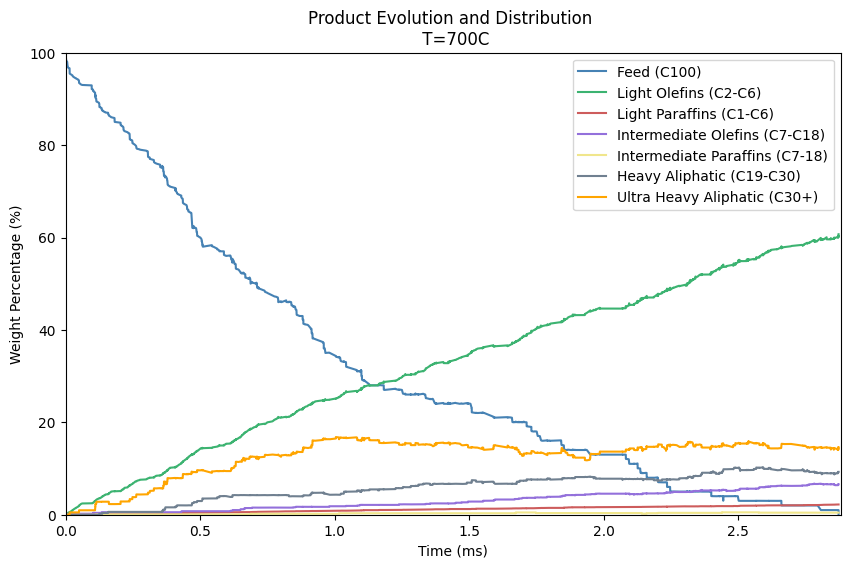

In [ ]:
#Create the line chart with all series on the same axes
fractions = ['Feed (C100)','Light Olefins (C2-C6)', 'Light Paraffins (C1-C6)', 'Intermediate Olefins (C7-C18)',
             'Intermediate Paraffins (C7-18)', 'Heavy Aliphatic (C19-C30)', 'Ultra Heavy Aliphatic (C30+)']

line_colors = ['steelblue', 'mediumseagreen', 'indianred', 'mediumpurple', 'khaki', 'slategray', 'orange']


plt.figure(figsize=(10, 6))


for i, fraction in enumerate(fractions):
    plt.plot(lumped_dist['Time'], lumped_dist[fraction], label=fraction, color=line_colors[i])


plt.xlabel("Time (ms)")
plt.ylabel("Weight Percentage (%)")
plt.title(f"Product Evolution and Distribution \n T={temp}C")
plt.xlim(0,2.88)
plt.ylim(0,100)
plt.legend()

plt.savefig(os.path.join(cwd,f'{temp}C_product.png'),dpi=300)
plt.show()